In [7]:
from imports import *
from utils import *
from model import *

dataset = 'DailyActivityMonitoring(DAM)'

batch_size = 8
traindata_folder = 'raw\\DailyActivityMonitoring\\testdata'
samples, labels = load_dataset(folder_path = traindata_folder)
traindataset = TimeSeriesDataset(samples, labels)
train_loader = DataLoader(traindataset, batch_size=batch_size, shuffle=True)

testdata_folder = 'raw\\DailyActivityMonitoring\\testdata'
samples, labels = load_dataset(folder_path = testdata_folder)
testdataset = TimeSeriesDataset(samples, labels)
test_loader = DataLoader(testdataset, batch_size=1, shuffle=False)

In [15]:
num_classes = 5

model = NET_1k_DAM(num_classes = num_classes)

total_weights = count_weights(model)
print(f"The network has {total_weights} weights that need to be deployed.")

model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
model = torch.quantization.prepare_qat(model, inplace=True)
model = torch.quantization.convert(model, inplace=True)

The network has 122 weights that need to be deployed.


In [10]:
# Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_filename = f"checkpoint/DAM-122-97.40_model.t7"

checkpoint = torch.load(model_filename, map_location=device)
model.load_state_dict(checkpoint['model'])

print(model) # The model has been quantized to int8

NET_1k_DAM(
  (channel1_conv): Sequential(
    (0): QuantizedConv1d(1, 3, kernel_size=(3,), stride=(1,), scale=0.029236789792776108, zero_point=15, padding=(1,))
    (1): ReLU()
    (2): QuantizedConv1d(3, 2, kernel_size=(3,), stride=(1,), scale=0.2035026252269745, zero_point=75, padding=(1,))
    (3): ReLU()
  )
  (channel2_conv): Sequential(
    (0): QuantizedConv1d(1, 3, kernel_size=(3,), stride=(1,), scale=0.030810095369815826, zero_point=66, padding=(1,))
    (1): ReLU()
    (2): QuantizedConv1d(3, 2, kernel_size=(3,), stride=(1,), scale=0.02409001998603344, zero_point=6, padding=(1,))
    (3): ReLU()
  )
  (channel3_conv): Sequential(
    (0): QuantizedConv1d(1, 2, kernel_size=(3,), stride=(1,), scale=0.039328593760728836, zero_point=3, padding=(1,))
    (1): ReLU()
    (2): QuantizedConv1d(2, 2, kernel_size=(2,), stride=(1,), scale=0.182743102312088, zero_point=19, padding=(1,))
    (3): ReLU()
  )
  (channel4_conv): Sequential(
    (0): QuantizedConv1d(1, 2, kernel_size=(3,), s

In [11]:
quantized_weights_list = print_quantized_weights(model)

Extracting weights from layer: channel1_conv.0
Weight Shape: (9,), Int8 Weights:
[-128   45  -19  -39 -128  -59  127  109   61]

Extracting weights from layer: channel1_conv.2
Weight Shape: (18,), Int8 Weights:
[ -20    6   17   39   92   62  -66 -127 -103    3   63   49  127   96
   95  -40   22  -19]

Extracting weights from layer: channel2_conv.0
Weight Shape: (9,), Int8 Weights:
[ 127   73  -23  127  105   64  -56  -59 -127]

Extracting weights from layer: channel2_conv.2
Weight Shape: (18,), Int8 Weights:
[  -6   13   61  -29 -127 -127  -23   16  -64   36   78   20 -119 -125
  -85  -69 -106 -128]

Extracting weights from layer: channel3_conv.0
Weight Shape: (6,), Int8 Weights:
[-128  -98   16  127  120   94]

Extracting weights from layer: channel3_conv.2
Weight Shape: (8,), Int8 Weights:
[ -52 -128  -18   91   31  -57  127   43]

Extracting weights from layer: channel4_conv.0
Weight Shape: (6,), Int8 Weights:
[-128   17  -82  127   70  102]

Extracting weights from layer: channel

The test accuracy after quantization is: 97.40%


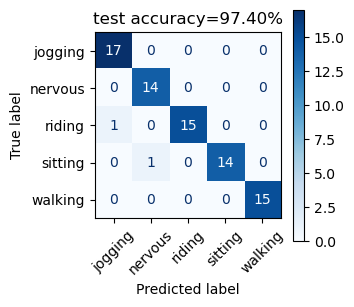

In [12]:
model.eval()
correct = 0
total = 0

predicted_count = []
labels_count = []

with torch.no_grad():
    for i, (x1, x2, x3, x4, labels) in enumerate(test_loader):
        outputs = model(x1, x2, x3, x4)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        predicted_count.append(predicted)
        labels_count.append(labels)

test_accuracy = 100 * correct / total

true_labels = [d for d in os.listdir(testdata_folder) if os.path.isdir(os.path.join(testdata_folder, d))]
conf_matrix = confusion_matrix(labels_count, predicted_count)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(true_labels))

print(f"The test accuracy after quantization is: {test_accuracy:.2f}%")

fig, ax = plt.subplots(figsize=(3, 3))
disp.plot(ax=ax, cmap='Blues')
plt.xticks(rotation=45)
plt.title(f'test accuracy={test_accuracy:.2f}%')
plt.show()